In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
import os
import cv2
from PIL import Image, ImageOps
from tifffile import imsave
import glob
import PIL
import shutil

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)

In [ ]:
!unzip "/content/gdrive/MyDrive/archive (2).zip"

Archive:  /content/gdrive/MyDrive/archive (2).zip
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1.nii  
  in

In [ ]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

VOLUME_SLICES=70
VOLUME_START_AT=70

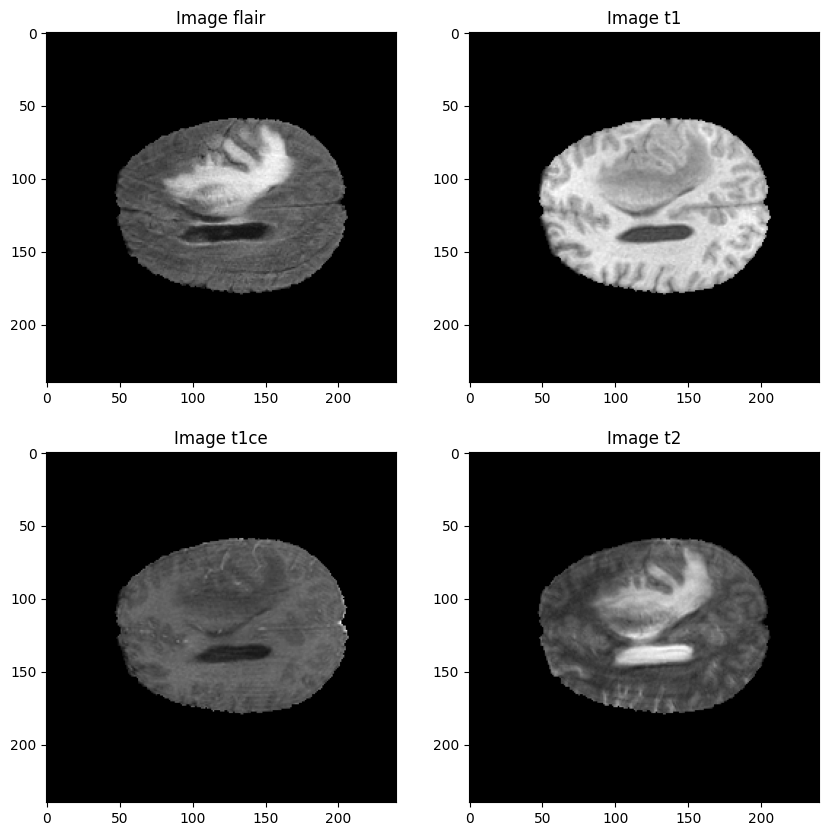

In [ ]:
TRAIN_DATASET_PATH = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/content/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (20, 20))
# slice_w = 25
# ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
# ax1.set_title('Image flair')
# ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
# ax2.set_title('Image t1')
# ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
# ax3.set_title('Image t1ce')
# ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
# ax4.set_title('Image t2')
# # ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
# # ax5.set_title('Mask')


f, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0][0].imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax[0][0].set_title('Image flair')

ax[0][1].imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax[0][1].set_title('Image t1')

ax[1][0].imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax[1][0].set_title('Image t1ce')



ax[1][1].imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax[1][1].set_title('Image t2')

plt.show()

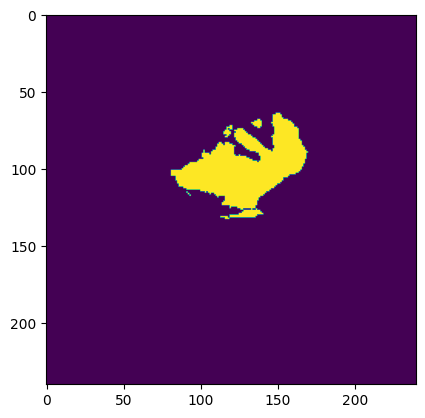

In [ ]:
plt.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])


In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    class_num = 3
    for i in range(1,4):
        intersection = K.sum(K.abs(y_true[:,:,:,i] * y_pred[:,:,:,i]))
        loss = ((2. * intersection ) / (K.sum(K.square(y_true[:,:,:,i])) + K.sum(K.square(y_pred[:,:,:,i])) + smooth))

        if i == 1:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
IMG_SIZE=128

In [ ]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);


train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
def generate_data(list_ids, batch_size, img_size):
    while True:
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        indexes = np.arange(len(list_ids))
        #indexes = indexes[index*batch_size:(index+1)*batch_size]
        np.random.shuffle(indexes)
        Batch_ids = [list_ids[k] for k in indexes[:batch_size]]

        # Initialization
        X = np.zeros((batch_size*VOLUME_SLICES, img_size[0], img_size[1], img_size[2]))
        #X = np.zeros((batch_size*VOLUME_SLICES, 150, 150, img_size[2]))
        y = np.zeros((batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((batch_size*VOLUME_SLICES, img_size[0], img_size[1], 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii')
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii')
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
              #X [j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[35:186,35:186,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        # Generate masks
        y[y==4] = 3
        mask = tf.one_hot(y, len(SEGMENT_CLASSES))
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        yield X/np.max(X), Y


def data_generator_wrapper(list_ids, batch_size, img_size=(IMG_SIZE, IMG_SIZE, 2)):
    if len(list_ids)==0 or batch_size<=0: return None
    return generate_data(list_ids, batch_size, img_size)

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, multiply, concatenate, Input, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.models import Model


In [ ]:
def inception_module(filters,inputs, ker_init):
    conv1x1 = Conv2D(filters, 1, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)

    conv3x3_reduce = Conv2D(filters, 1, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv3x3 = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3x3_reduce)

    conv5x5_reduce = Conv2D(filters, 1, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv5x5 = Conv2D(filters, 5, activation='relu', padding='same', kernel_initializer=ker_init)(conv5x5_reduce)

    pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    pool_proj = Conv2D(filters, 1, activation='relu', padding='same', kernel_initializer=ker_init)(pool)

    inception_output = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=3)
    return inception_output

def build_inception_resunet(input_shape, ker_init, dropout):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    skip1 = conv1

   # pool = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

    conv = inception_module(32,conv1, ker_init)
    skip2 = conv
    pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    skip3 = conv2

   # pool = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    conv = inception_module(64,conv2, ker_init)
    skip4 = conv
    pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    skip5 = conv3

   # pool = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    conv = inception_module(128,conv3, ker_init)
    skip6 = conv
    pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    skip7 = conv4

   # pool = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)
    conv = inception_module(256,conv4, ker_init)
    skip8 = conv
    pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)


    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([skip8, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)
    conv6_res = Conv2D(256, 1, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)
    conv6_res = Add()([conv6_res, conv6])

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv6_res))
    merge7 = concatenate([skip6, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
    conv7_res = Conv2D(128, 1, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
    conv7_res = Add()([conv7_res, conv7])

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv7_res))
    merge8 = concatenate([skip4, up8], axis=3)
    conv8 = Conv2D(54, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)
    conv8_res = Conv2D(64, 1, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)
    conv8_res = Add()([conv8_res, conv8])

    up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv8_res))
    merge = concatenate([skip2, up], axis=3)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
    conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    conv_res = Conv2D(32, 1, activation='relu', padding='same', kernel_initializer=ker_init)(conv)
    conv_res = Add()([conv_res, conv])

    conv_res = Conv2D(4, (1, 1), activation='softmax')(conv_res)

    return Model(inputs=inputs, outputs=conv_res)

In [ ]:
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate, Add
# from tensorflow.keras.models import Model

# def inception_module(inputs, ker_init):
#     conv1x1 = Conv2D(32, 1, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)

#     conv3x3_reduce = Conv2D(32, 1, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
#     conv3x3 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3x3_reduce)

#     conv5x5_reduce = Conv2D(32, 1, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
#     conv5x5 = Conv2D(32, 5, activation='relu', padding='same', kernel_initializer=ker_init)(conv5x5_reduce)

#     pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(inputs)
#     pool_proj = Conv2D(32, 1, activation='relu', padding='same', kernel_initializer=ker_init)(pool)

#     inception_output = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=3)
#     return inception_output


# def build_inception_resunet(inputs, ker_init, dropout):
#     conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
#     conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
#     skip1 = conv1

#     pool = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)

#     conv = inception_module(pool, ker_init)
#     skip2 = conv
#     pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv)
#  ##
#     conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
#     skip3 = conv2

#     pool = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
#     conv= inception_module(pool, ker_init)
#     skip4 = conv
#     pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv)

# ##
#     conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
#     skip5 = conv3

#     pool = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
#     conv= inception_module(pool, ker_init)
#     skip6 =conv
#     pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv)
# ##

#     conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
#     conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)

#     up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv5))
#     merge6 = concatenate([skip4, up6], axis=3)
#     conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
#     conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)
#     conv6_res = Conv2D(256, 1, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)
#     conv6_res = Add()([conv6_res, conv6])

#     up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv6_res))
#     merge7 = concatenate([skip3, up7], axis=3)
#     conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
#     conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
#     conv7_res = Conv2D(128, 1, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
#     conv7_res = Add()([conv7_res, conv7])

#     up8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv7_res))
#     merge8 = concatenate([skip2, up8], axis=3)
#     conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
#     conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)
#     conv8_res = Conv2D(32, 1, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)
#     conv8_res = Add()([conv8_res, conv8])

#     up = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling2D(size=(2, 2))(conv8_res))
#     merge = concatenate([skip1, up], axis=3)
#     conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge)
#     conv = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv)
#     conv_res = Conv2D(32, 1, activation='relu', padding='same', kernel_initializer=ker_init)(conv)
#     conv_res = Add()([conv_res, conv])

#     conv10 = Conv2D(4, (1, 1), activation='softmax')(conv_res)

#     return Model(inputs=inputs, outputs=conv10)


In [ ]:
from tensorflow.keras.optimizers import Adam


input_shape = (128, 128, 2)
num_classes = 4

ker_init = 'he_normal'
dropout = 0.5

model = build_inception_resunet(input_shape, ker_init, dropout)



In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_521 (Conv2D)            (None, 128, 128, 32  608         ['input_20[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_522 (Conv2D)            (None, 128, 128, 32  9248        ['conv2d_521[0][0]']             
                                )                                                           

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

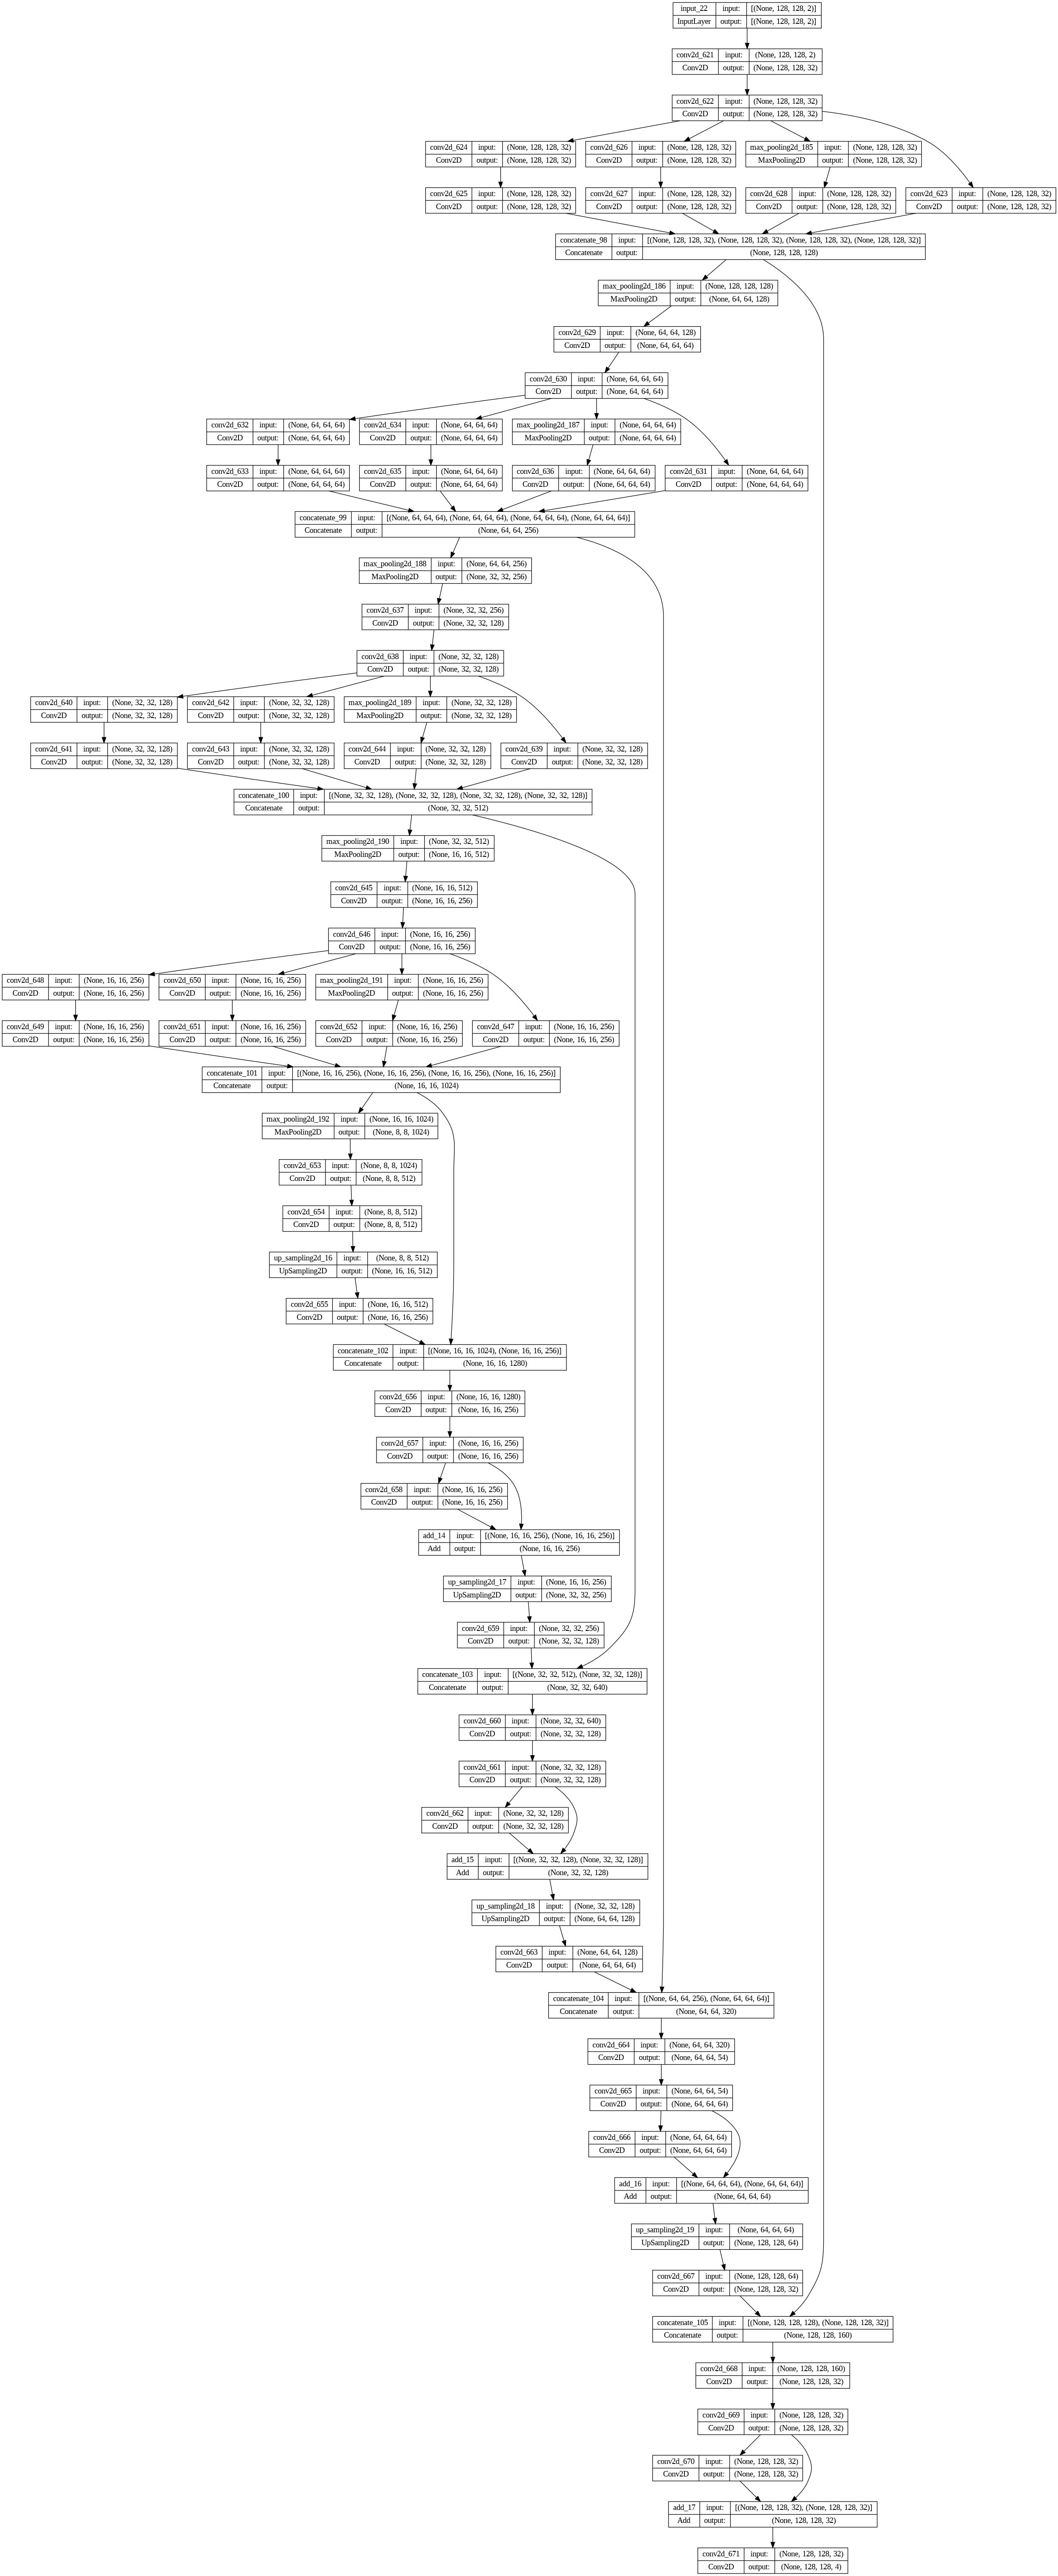

In [ ]:
plot_filename = 'model_plot.png'

# Use the plot_model function to generate the visualization and save it to the file
plot_model(model, to_file=plot_filename, show_shapes=True, show_layer_names=True)

In [ ]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=5, min_lr=0.000001, verbose=2),
        csv_logger
    ]

In [ ]:
batch_size=1
history = model.fit(data_generator_wrapper(train_ids, batch_size=batch_size),
                    epochs=150,
                    steps_per_epoch=max(1, len(train_ids)//batch_size),
                    callbacks= callbacks,
                    validation_data=data_generator_wrapper(val_ids, batch_size=batch_size),
                    validation_steps=max(1, len(val_ids)//batch_size),
                    initial_epoch=0
                    )
model.save("/content/gdrive/MyDrive/Brain Tumor/finalOutputwithincep0.h5")

Epoch 1/150
249/249 [==============================] - 275s 994ms/step - loss: 0.5927 - accuracy: 0.9777 - mean_io_u_4: 0.5535 - dice_coef: 0.0707 - precision: 0.9759 - sensitivity: 0.9651 - specificity: 0.9942 - dice_coef_necrotic: 0.0435 - dice_coef_edema: 0.1294 - dice_coef_enhancing: 0.0393 - val_loss: 0.0693 - val_accuracy: 0.9829 - val_mean_io_u_4: 0.7092 - val_dice_coef: 0.0541 - val_precision: 0.9828 - val_sensitivity: 0.9828 - val_specificity: 0.9943 - val_dice_coef_necrotic: 0.0408 - val_dice_coef_edema: 0.0987 - val_dice_coef_enhancing: 0.0228 - lr: 0.0010
Epoch 2/150
249/249 [==============================] - 245s 985ms/step - loss: 0.0684 - accuracy: 0.9825 - mean_io_u_4: 0.6348 - dice_coef: 0.1219 - precision: 0.9837 - sensitivity: 0.9803 - specificity: 0.9946 - dice_coef_necrotic: 0.0797 - dice_coef_edema: 0.2002 - dice_coef_enhancing: 0.0857 - val_loss: 0.0577 - val_accuracy: 0.9853 - val_mean_io_u_4: 0.7284 - val_dice_coef: 0.1889 - val_precision: 0.9924 - val_sensitiv

In [ ]:
test_generator=data_generator_wrapper(test_ids, batch_size=2)

In [ ]:
print("Evaluate on test data")

results = model.evaluate(test_generator, batch_size=2, callbacks= callbacks)

print("test loss, test acc:", results)

Evaluate on test data
  25625/Unknown - 10803s 422ms/step - loss: 0.0285 - accuracy: 0.9939 - mean_io_u: 0.9236 - dice_coef: 0.6508 - precision: 0.9939 - sensitivity: 0.9932 - specificity: 0.9979 - dice_coef_necrotic: 0.4797 - dice_coef_edema: 0.7628 - dice_coef_enhancing: 0.6794

In [ ]:
model = keras.models.load_model('/content/gdrive/MyDrive/Brain Tumor/finalOutputwithincep.h5',
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)


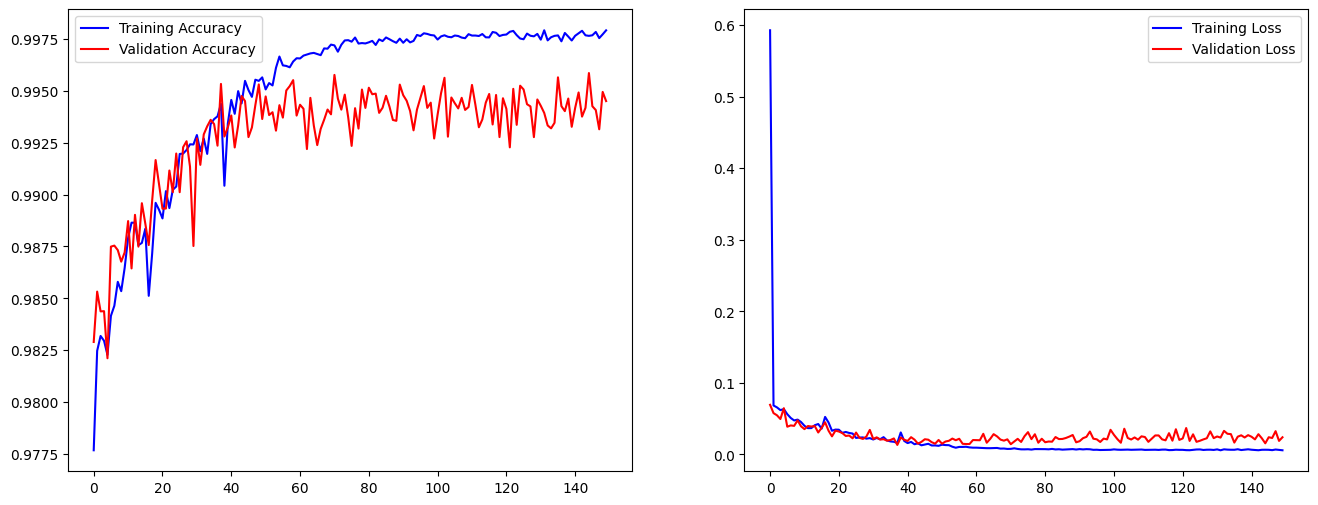

In [ ]:


# # Convert the model to TensorFlow Lite format
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the converted model to a file
# # with open('/content/gdrive/MyDrive/Brain Tumor/New_Untitled6.tflite', 'wb') as f:
# #     f.write(tflite_model)

import pandas as pd
import matplotlib.pyplot as plt

history = pd.read_csv('/content/gdrive/MyDrive/training.log', sep=',', engine='python')

hist = history

acc = hist['accuracy']
val_acc = hist['val_accuracy']

epoch = range(len(acc))

loss = hist['loss']
val_loss = hist['val_loss']

train_dice = hist['dice_coef']
val_dice = hist['val_dice_coef']

f, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()

plt.show()

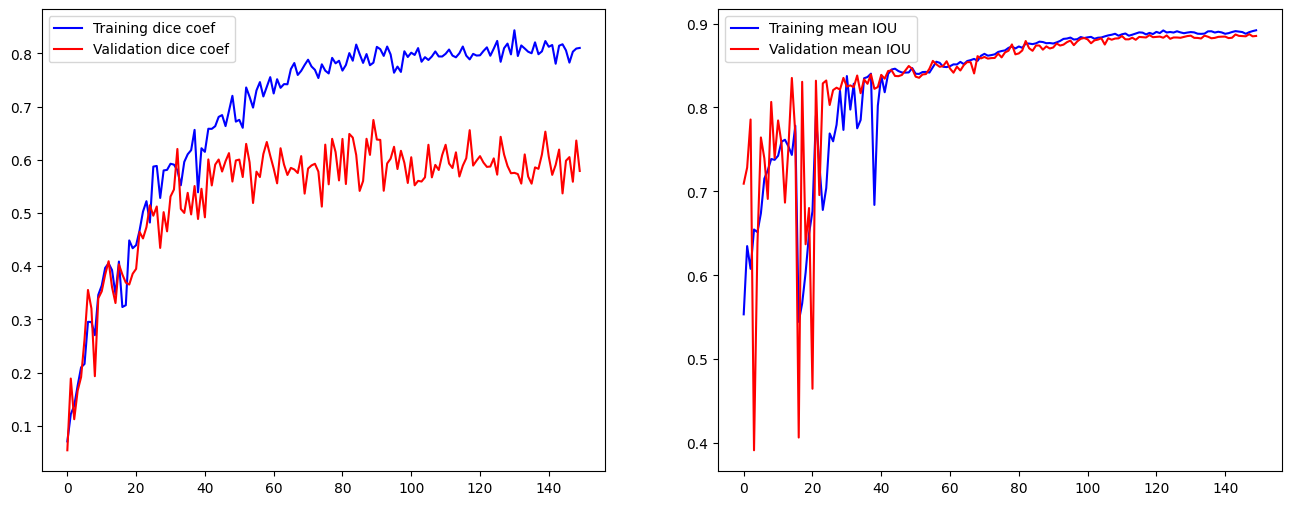

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(epoch, train_dice, 'b', label='Training dice coef')
ax[0].plot(epoch, val_dice, 'r', label='Validation dice coef')
ax[0].legend()



ax[1].plot(epoch, hist['mean_io_u_4'], 'b', label='Training mean IOU')
ax[1].plot(epoch, hist['val_mean_io_u_4'], 'r', label='Validation mean IOU')
ax[1].legend()


In [ ]:
data_dir="/content/BraTS2020_TrainingData"

In [ ]:
# |def predict_tumors(case, start_slice = 60):
#     path = data_dir + "/" + case
#     X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

#     flair = nib.load(path + "/" + case + "_flair.nii").get_fdata()
#     mask = nib.load(path + "/" + case + "_seg.nii").get_fdata()
#     ce = nib.load(path + "/" + case + "_t1ce.nii").get_fdata()

#     for j in range(VOLUME_SLICES):
#         X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
#         X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

#     pred = model.predict(X/np.max(X), verbose=1)

#     core = pred[:,:,:,1]
#     edema= pred[:,:,:,2]
#     enhancing = pred[:,:,:,3]

#     f, ax = plt.subplots(2, 3)

#     for i in range(2): # for each image, add brain background
#         for j in range(3):
#             ax[i, j].imshow(cv2.resize(flair[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

#     ax[0, 0].imshow(cv2.resize(flair[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
#     ax[0, 0].title.set_text('Original image flair')

#     mask=cv2.resize(mask[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
#     ax[0, 1].imshow(mask, cmap="Reds", interpolation='none', alpha=0.3)
#     ax[0, 1].title.set_text('Ground truth')

#     ax[0, 2].imshow(pred[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
#     ax[0, 2].title.set_text('all classes')

#     ax[1, 0].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
#     ax[1, 0].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')

#     ax[1, 1].imshow(core[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
#     ax[1, 1].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')

#     ax[1, 2].imshow(enhancing[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
#     ax[1, 2].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

#     plt.tight_layout()
#     plt.show()
#     print("\n")

# for ids in np.random.choice(train_ids, size=5, replace=False):
#     predict_tumors(ids)

In [ ]:
# def predict_tumors(case, start_slice = 60):
#     path = data_dir + "/" + case
#     X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

#     flair = nib.load(path + "/" + case + "_flair.nii").get_fdata()
#     mask = nib.load(path + "/" + case + "_seg.nii").get_fdata()
#     ce = nib.load(path + "/" + case + "_t1ce.nii").get_fdata()

#     for j in range(VOLUME_SLICES):
#         X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
#         X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

#     pred = model.predict(X/np.max(X), verbose=1)

#     core = pred[:,:,:,1]
#     edema= pred[:,:,:,2]
#     enhancing = pred[:,:,:,3]

#     f, ax = plt.subplots(2, 3)

#     for i in range(2): # for each image, add brain background
#         for j in range(3):
#             ax[i, j].imshow(cv2.resize(flair[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

#     ax[0, 0].imshow(cv2.resize(flair[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
#     ax[0, 0].title.set_text('Original image flair')

#     mask=cv2.resize(mask[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
#     ax[0, 1].imshow(mask, cmap="Reds", interpolation='none', alpha=0.3)
#     ax[0, 1].title.set_text('Ground truth')

#     ax[0, 2].imshow(pred[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
#     ax[0, 2].title.set_text('all classes')

#     ax[1, 0].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
#     ax[1, 0].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')

#     ax[1, 1].imshow(core[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
#     ax[1, 1].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')

#     ax[1, 2].imshow(enhancing[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
#     ax[1, 2].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

#     plt.tight_layout()
#     plt.show()
#     print("\n")

# for ids in np.random.choice(train_ids, size=5, replace=False):
#     predict_tumors(ids)



NameError: ignored

In [ ]:

def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def showPredictsById(case, start_slice = 70):
    path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)),cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()


In [ ]:
IMG_SIZE=128

3/3 [==============================] - 0s 142ms/step


<Figure size 640x480 with 0 Axes>

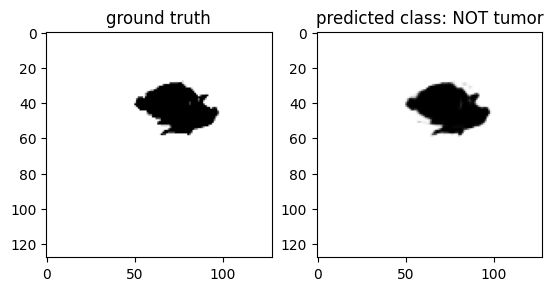

<Figure size 640x480 with 0 Axes>

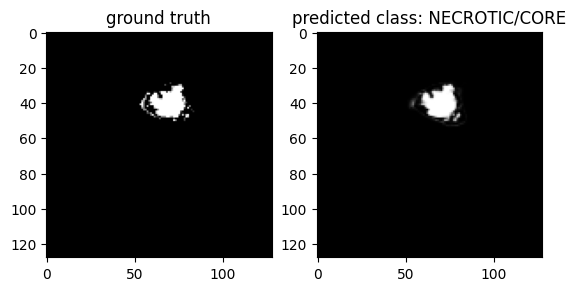

<Figure size 640x480 with 0 Axes>

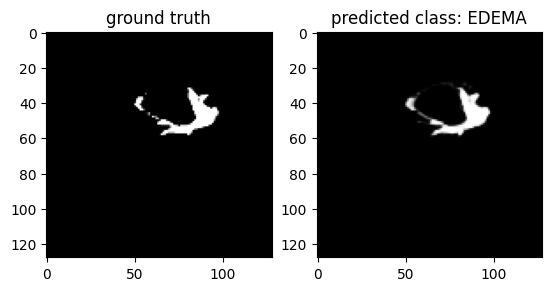

<Figure size 640x480 with 0 Axes>

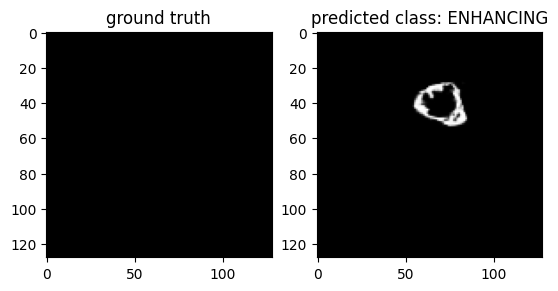

In [ ]:
case="100"
path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path, case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=10



for eval_class in SEGMENT_CLASSES:

    gt_single_class = gt.copy()

    gt_single_class[gt_single_class != eval_class] = -1 # use only one class for per class evaluation

    resized_gt = cv2.resize(gt_single_class[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    plt.figure()
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(resized_gt, cmap="gray")
    axarr[0].title.set_text('ground truth')
    axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
    axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
    plt.show()

# i=40 # slice at
# eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



# gt[gt != eval_class] = 1 # use only one class for per class evaluation

# resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

# plt.figure()
# f, axarr = plt.subplots(1,2)
# axarr[0].imshow(resized_gt, cmap="gray")
# axarr[0].title.set_text('ground truth')
# axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
# axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
# plt.show()


In [ ]:
# Combine predicted classes into a single image
segmentation_map = np.zeros_like(core)
segmentation_map[core > 0.06] = 1
segmentation_map[edema > 0.06] = 2
segmentation_map[enhancing > 0.06] = 3


segmentation_map.shape


(70, 128, 128)

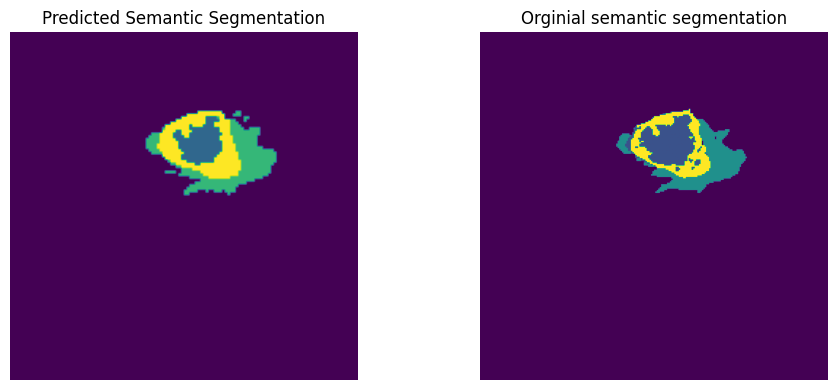

In [ ]:
# Plot the segmentation map
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 4))


axes[0].imshow(segmentation_map[10, :, :])
axes[0].axis('off')
axes[0].set_title('Predicted Semantic Segmentation')

axes[1].imshow(gt[:,:,80])
axes[1].axis('off')
axes[1].set_title("Orginial semantic segmentation")
plt.tight_layout()
plt.show()